In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_classes = 1
num_epochs = 30
batch_size = 20
learning_rate = 0.001
use_gpu = True
img_size = 64


In [3]:
# Model responsible for generating our Latent space.
#Latent space, Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution, Batch Normalization, ReLU 연산을 합친 함수
        def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
            layer = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(num_features=output_channel),
                nn.ReLU()
                
            )
            return layer

        # Down Path ######################
        # Contracting path
        # conv 기본적으로 kernel size 3*3 에 stride 1으로 ■■■□□□ □■■■□□ □□■■■□ □□□■■■ =>2칸씩 크기가 줄어든다
        # 256x256x3 => 256x256x32
        self.conv1 = nn.Sequential(
            CBR2d(3, 32),
            CBR2d(32, 32)
        )
        # 256x256x32 => 128x128x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 128x128x32 => 128x128x64
        self.conv2 = nn.Sequential(
            CBR2d(32, 64),
            CBR2d(64, 64)
        )
        # 128x128x64 => 64x64x64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 64x64x64 => 64x64x128
        self.conv3 = nn.Sequential(
            CBR2d(64, 128),
            CBR2d(128, 128)
        )
        # 64x64x128 => 32x32x128
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 32x32x128 => 32x32x256
        # Contracting path 마지막에 Dropout 적용
        self.conv4 = nn.Sequential(
            CBR2d(128, 256),
            CBR2d(256, 256),
            nn.Dropout(p=0.5)
        )
        # 32x32x256 => 16x16x256
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path 끝
        ###################################

        # Bottlneck 구간 #########512###########
        # 16x16x256 => 16x16x512
        self.bottleNeck = nn.Sequential(
            CBR2d(256, 512),
            CBR2d(512, 512),
        )
        # Bottlneck 구간 끝
        ###################################

    def forward(self, x):
        # Contracting path
        # 572x572x1 => 568x568x64
        layer1 = self.conv1(x)

        # Max Pooling
        # 568x568x64 => 284x284x64
        out = self.pool1(layer1)

        # 284x284x64 => 280x280x128
        layer2 = self.conv2(out)

        # Max Pooling
        # 280x280x128 => 140x140x128
        out = self.pool2(layer2)

        # 140x140x128 => 136x136x256
        layer3 = self.conv3(out)

        # Max Pooling
        # 136x136x256 => 68x68x256
        out = self.pool3(layer3)

        # 68x68x256 => 64x64x512
        layer4 = self.conv4(out)

        # Max Pooling
        # 64x64x512 => 32x32x512
        out = self.pool4(layer4)

        # bottleneck
        # 32x32x512 => 28x28x1024
        bottleNeck = self.bottleNeck(out)

        return layer1, layer2, layer3, layer4, bottleNeck

# Model responsible for reconstruct the image form our Latent space.
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution, Batch Normalization, ReLU 연산을 합친 함수
        def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
            layer = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(num_features=output_channel),
                nn.ReLU()
            )
            return layer

        # Up Path #########################
        # Expanding path
        # channel 수를 감소 시키며 Up-Convolution
        # 16x16x512 => 32x32x256
        self.upconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)

        # Up-Convolution 이후 channel = 256
        # Contracting path 중 같은 단계의 Feature map을 가져와 Up-Convolution 결과의 Feature map과 Concat 연산
        # => channel = 512 가 됩니다.
        # forward 부분을 참고해주세요
        # 32x32x512 => 32x32x256
        self.ex_conv1 = nn.Sequential(
            CBR2d(512, 256),
            CBR2d(256, 256)
        )

        # 32x32x256 => 64x64x128
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        # 64x64x256 => 64x64x128
        self.ex_conv2 = nn.Sequential(
            CBR2d(256, 128),
            CBR2d(128, 128)
        )

        # 64x64x128 => 128x128x64
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        # 128x128x128 => 128x128x64
        self.ex_conv3 = nn.Sequential(
            CBR2d(128, 64),
            CBR2d(64, 64)
        )

        # 128x128x64 => 256x256x32
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

        # 256x256x64 => 256x256x32
        self.ex_conv4 = nn.Sequential(
            CBR2d(64, 32),
            CBR2d(32, 32),

        )

        # 논문 구조상 output = 2 channel
        # train 데이터에서 세포 / 배경을 검출하는것이 목표여서 class_num = 1로 지정
        # 256x256x32 => 256x256x1
        self.fc = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        
    def forward(self, x, layer1, layer2, layer3, layer4):
        # Expanding path
        # 28x28x1024 => 56x56x512
        upconv1 = self.upconv1(x)

        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 56x56x512 => 56x56x1024
        cat1 = torch.cat((transforms.CenterCrop((upconv1.shape[2], upconv1.shape[3]))(layer4), upconv1), dim=1)
        # 레이어 4를 중간 기준으로 upconv1 의 h(upconv1.shape[2]),w(upconv1.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # 56x56x1024 => 52x52x512
        ex_layer1 = self.ex_conv1(cat1)

        # 52x52x512 => 104x104x256
        upconv2 = self.upconv2(ex_layer1)

        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 104x104x256 => 104x104x512
        cat2 = torch.cat((transforms.CenterCrop((upconv2.shape[2], upconv2.shape[3]))(layer3), upconv2), dim=1)
        # 레이어 3를 중간 기준으로 upconv2 의 h(upconv2.shape[2]),w(upconv2.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # 104x104x512 => 100x100x256
        ex_layer2 = self.ex_conv2(cat2)

        # 100x100x256 => 200x200x128
        upconv3 = self.upconv3(ex_layer2)

        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 200x200x128 => 200x200x256
        cat3 = torch.cat((transforms.CenterCrop((upconv3.shape[2], upconv3.shape[3]))(layer2), upconv3), dim=1)
        # 레이어 2를 중간 기준으로 upconv3 의 h(upconv3.shape[2]),w(upconv3.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # 200x200x256 => 196x196x128
        ex_layer3 = self.ex_conv3(cat3)

        # 196x196x128=> 392x392x64
        upconv4 = self.upconv4(ex_layer3)

        # Contracting path 중 같은 단계의 Feature map을 가져와 합침
        # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
        # 392x392x64 => 392x392x128
        cat4 = torch.cat((transforms.CenterCrop((upconv4.shape[2], upconv4.shape[3]))(layer1), upconv4), dim=1)
        # 레이어 1를 중간 기준으로 upconv4 의 h(upconv4.shape[2]),w(upconv4.shape[3]) 만큼 잘라서 □■ 나란히 연결

        # 392x392x128 => 388x388x64
        out = self.ex_conv4(cat4)

        # 388x388x64 => 388x388x1
        out = self.fc3(out)
        out = F.relu(out)
        out = torch.tanh(out) # last layer before output is tanh, since the images are normalized and 0-centered

        return out
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        layer1, layer2, layer3, layer4, latent = self.encoder(x)
        x_recon = self.decoder(latent, layer1, layer2, layer3, layer4)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

#The model’s parameters that need to be trained.
num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 7765985


torch.Size([3, 64, 64])


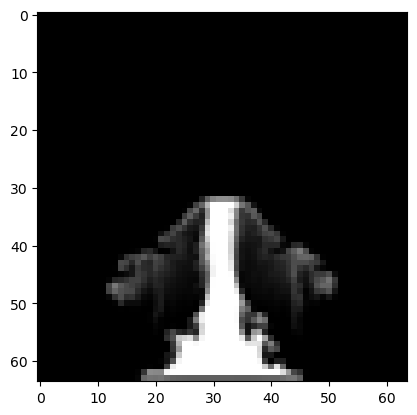

In [4]:
#이미지 흑백으로 열기
path1 = "E:\Project_Ch00cy\CGVR\TextureSynthesis\deep-InterpolationIMG\Test\FindTwo\draw-78.bmp"
path2 = "E:\Project_Ch00cy\CGVR\TextureSynthesis\deep-InterpolationIMG\Test\FindTwo\draw-84.bmp"

tf_toTensor = ToTensor()
image_pil1 = Image.open(path1)
image_bw1 = tf_toTensor(image_pil1.resize((img_size,img_size)))
image_pil2 = Image.open(path2)
image_bw2 = tf_toTensor(image_pil2.resize((img_size,img_size)))


print(image_bw1.shape)

plt.imshow(image_bw2.permute(1,2,0))
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
plt.ion()

# Util function to display the images
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


In [6]:
import torchsummary

torchsummary.summary(autoencoder.encoder, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

TypeError: Decoder.forward() missing 4 required positional arguments: 'layer1', 'layer2', 'layer3', and 'layer4'

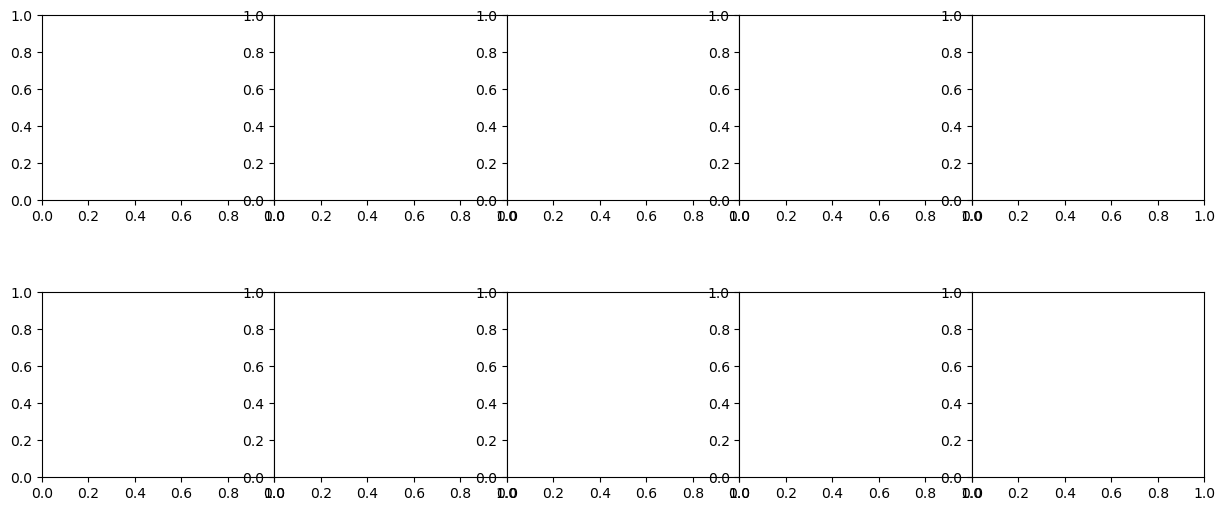

In [7]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1.unsqueeze(0))

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2.unsqueeze(0))

        latent = list(latent_1[:-1])
        # interpolation of the two latent vectors
        inter_latent = latent.append(lambda1 * latent_1[-1] + (1- lambda1) * latent_2[-1])

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
# We start off by taking two images from the dataset, and linearly interpolate between them
for ind,l in enumerate(lambda_range):
    inter_image = interpolation(float(l), autoencoder, image_bw1, image_bw1)
    # inter_image = to_img(inter_image)
    # image = inter_image.numpy()
   
    # axs[ind].imshow(image[0,0,:,:], cmap='gray')
    # axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 